In [350]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.max_rows=10
%matplotlib inline

In [391]:
# %load network-benchmark.py
#!/usr/bin/env python3

import configparser
import glob
import io

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


TEST_RESULT_DIR = \
    "/Users/esteele/tmp/wifi-test/root/wifi-test-results/test-run-{0}"
TEST_RESULT_METADATA_FILE = TEST_RESULT_DIR + "/metadata.ini"
TEST_RESULT_FILES_PATTERN = TEST_RESULT_DIR + "/*.csv"


def get_test_run_results(test_run_id):
    test_result_files_glob = TEST_RESULT_FILES_PATTERN.format(test_run_id)
    result_sio = io.StringIO()
    for csv in glob.iglob(test_result_files_glob):
        with open(csv) as f:
            result_sio.write(f.read())

    # Prime for reading
    result_sio.seek(0)
    return result_sio


def get_dataframe_from_test_run(test_run_id):
    raw_run_data = get_test_run_results(test_run_id)
    summary_data = pd.read_csv(raw_run_data,
                               comment="#",
                               names=["client_id",
                                      "timestamp",
                                      "bytes_per_sec"])
    # Create a time_offset column
    summary_data["time_offset"] = \
        summary_data["timestamp"] - min(summary_data["timestamp"])
    return summary_data


def get_tick_labels(min_value, max_value, labels_count):
    return list(range(int(np.floor(min_value)),
                      int(np.ceil(max_value)),
                      int(max_value/labels_count))) + \
            [max_value]


def get_graph_title_for_run(test_run_id):
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(test_run_id))
    # Don't count the global section
    client_count = len(config.sections()) - 1
    stream_count = sum([int(config[s]["parallel_run_count"])
                        for s in config.sections()
                        if s != "global"])
    bandwidth_desc = "{0} bytes/sec".format(
        config["global"]["test_bandwidth_bps"]
    )
    title = "Run {0} against {1}{2}.\n{3} clients ({4} streams @ {5} each)" \
            .format(
                test_run_id,
                config["global"]["test_server_hostname"],
                config["global"]["extra_run_description"],
                client_count,
                stream_count,
                bandwidth_desc
            )
    return title


def show_run_df_as_line_graph(df, title, ax):
    pivot_df = df.pivot(index="time_offset",
                        columns="client_id",
                        values="bytes_per_sec")
    ax = pivot_df.plot(figsize=(20, 10), ax=ax)
    ax.set_xlabel("Elapsed time (sec)")
    ax.set_xbound(lower=0)
    ax.set_ylabel("Throughput (bytes/sec)")
    ax.axhline(y=250000,
               color='0.75',
               linestyle="--")
    ax.annotate(" 480p bitrate",
                (max(df["time_offset"]), 250000))
    ax.set_title(title)


def show_multiple_run_ids_as_line_graph(run_ids):
    fig, axes = plt.subplots(1, len(run_ids),
                             sharex=True,
                             sharey=True,
                             squeeze=False)

    for idx, run_id in enumerate(run_ids):
        summary_data = get_dataframe_from_test_run(run_id)
        show_run_df_as_line_graph(
            summary_data,
            get_graph_title_for_run(run_id),
            ax=axes[0][idx]
        )


def show_run_df_as_boxplot(df, title):
    labels = get_tick_labels(min(df["time_offset"]),
                             max(df["time_offset"]),
                             10)
    ax2 = df.boxplot(column="bytes_per_sec",
                     by="time_offset",
                     figsize=(10, 10))
    ax2.set_xlabel("Elapsed time (sec)")
    ax2.grid()
    ax2.set_xticks(labels)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Throughput (bytes/sec)")
    ax2.axhline(y=250000, color='0.75', linestyle="--")
    ax2.annotate("       480p bitrate", (max(df["time_offset"]), 250000))
    ax2.set_title(title)


In [392]:
run_id = 675426226    # 2 good clients, 15 streams
run_id2 = 544558453   # 2 good clients, 20 streams
run_id = 1268137335   # 2 good clients, 14 streams + 1 bad client w/ 1 stream
run_id = 552561623   # 2 good clients, 14 streams + 1 bad client w/ 1 stream. Synced
run_id = 2141499876  # 1 client, 1 stream. new token bucket implementation from here on.
run_id = 2140191644  # 8 clients, 2 streams @250KBps (except for client01, with 1 stream)
run_id = 1570619147  # 8 clients, 1 stream @250KBps
run_id = 1026668266  # 1 client, 1 stream @250KBps
run_id = 1002549644  # 4 clients, 1 stream @250KBps
run_id = 1019479315  # 5 clients, 1 stream @250KBps
run_id = 848317091   # 8 clients, 1 stream @250KBps
run_id = 1721738302  # 6 clients, 1 stream @250KBps
run_id = 267408816   # 7 clients (1-7), 1 stream @250KBps
run_id = 1094073741  # 7 clients (1-6,8), 1 stream @250KBps
run_id = 1224571019  # 8 clients, 1 stream @250KBps
run_id = 1816880742  # 7 clients, 2 stream @250KBps
run_id = 1702631689  # 4 clients (1-4), 2 stream @250KBps
run_id = 1160174775  # 5 clients, 2 stream @250KBps
run_id = 602949541   # 6 clients, 2 steram @250KBps
run_id = 957447945   # 6 clients, 2 steram @500KBps
run_id = 342202255   # 6 clients, 2 stream @1MBps
run_id = 1355222921  # 9 clients, 1 steram @250KBps (all rpi3 above)
run_id = 1804322418  # 7 clients, 1 stream @250KBps (RPI0w)
run_id = 1846334772  # 9 clients, 1 stream @250KBps (RPI0w)
run_id = 1079992158  # 9 clients, 1 stream @250KBps (rpi3)
run_id = 1241842586  # 9 clients, 1 stream @250KBps (neo+rt5370)
run_id = 1395987649  # 9 clients, 1 stream @250KBps (neo+rt5370)
run_id = 1459308851  # 9 clients, 2 sterams @250KBps (neo+rt5370)
run_id = 1797864569  # 9 clients, 1 stream @250KBps (neo+ar9271)
# Above here, metadata is incorrect/absent
run_id = 123456789  # 3 clients, 4 total streams @250KBps (rpi3)
run_id = 99991      # 4 clients, 4 total sterams @250KBps (rpi3)
run_id = 99992      # 4 clients, 8 total sterams @250KBps (rpi3)
run_id = 99993      # 4 clients, 12 total sterams @250KBps (rpi3)
#run_id = 99994      # 4 clients, 16 total sterams @250KBps (rpi3)
#run_id = 99995      # 4 clients, 20 total sterams @250KBps (rpi3)
#run_id = 99996      # 4 clients, 24 total sterams @250KBps (rpi3)
#run_id = 99997      # 4 clients, 28 total sterams @250KBps (rpi3)
#run_id = 911726247  # 6 clients, 12 total steams (rpi3)
run_id = 1078739015 # 2 clients, 12 total streams (rpi3)
#summary_data = get_dataframe_from_test_run(run_id)

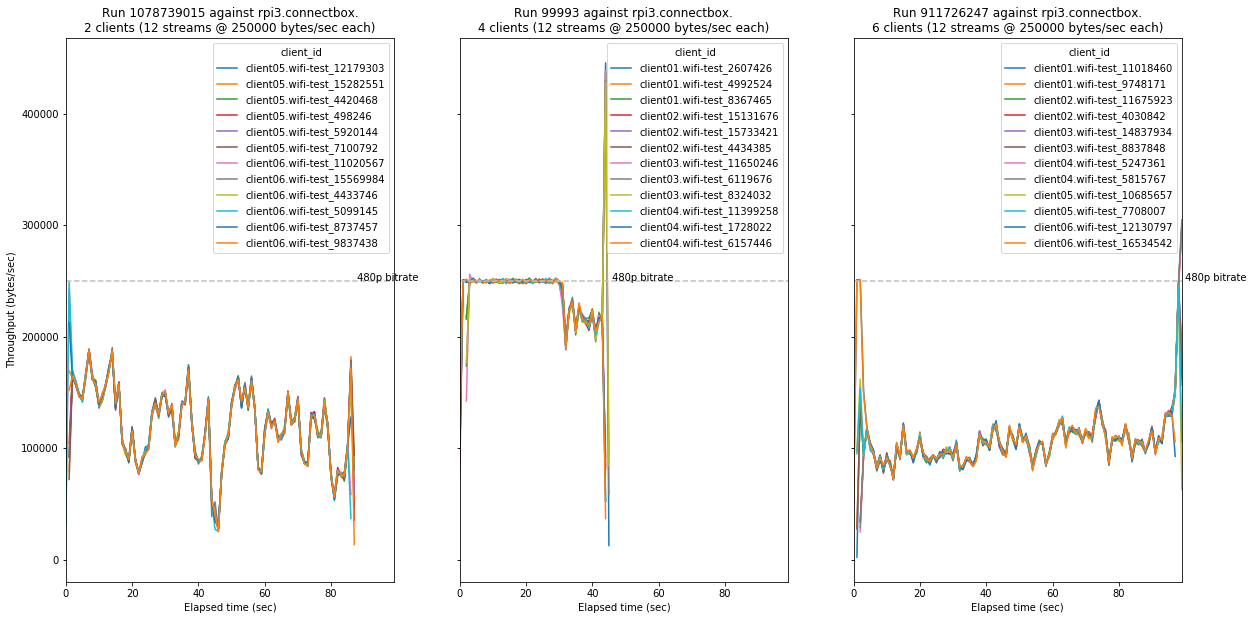

In [395]:
show_multiple_run_ids_as_line_graph([1078739015, 99993, 911726247])

In [394]:
#show_run_df_as_boxplot(summary_data,                   "Wifi throughput test id: {0}".format(run_id))